In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

In [74]:
df = pd.read_csv('merged_car_sales_with_features.csv')

df['waktu'] = pd.to_datetime(df['waktu'])
df = df.set_index('waktu')

df.info()
print(df.describe())
print(df.head(60))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54 entries, 2021-01-01 to 2025-07-01
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DAIHATSU                   54 non-null     float64
 1   HONDA                      54 non-null     float64
 2   MITSUBISHI                 54 non-null     float64
 3   SUZUKI                     54 non-null     float64
 4   TOYOTA                     54 non-null     float64
 5   bi_policy_rate_pct         54 non-null     object 
 6   inflation_yoy_pct          54 non-null     object 
 7   consumer_confidence_index  54 non-null     object 
 8   is_lebaran_season          54 non-null     int64  
 9   is_giias_month             54 non-null     int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 4.6+ KB
           DAIHATSU         HONDA    MITSUBISHI        SUZUKI        TOYOTA  \
count     54.000000     54.000000     54.000000     54.000000   

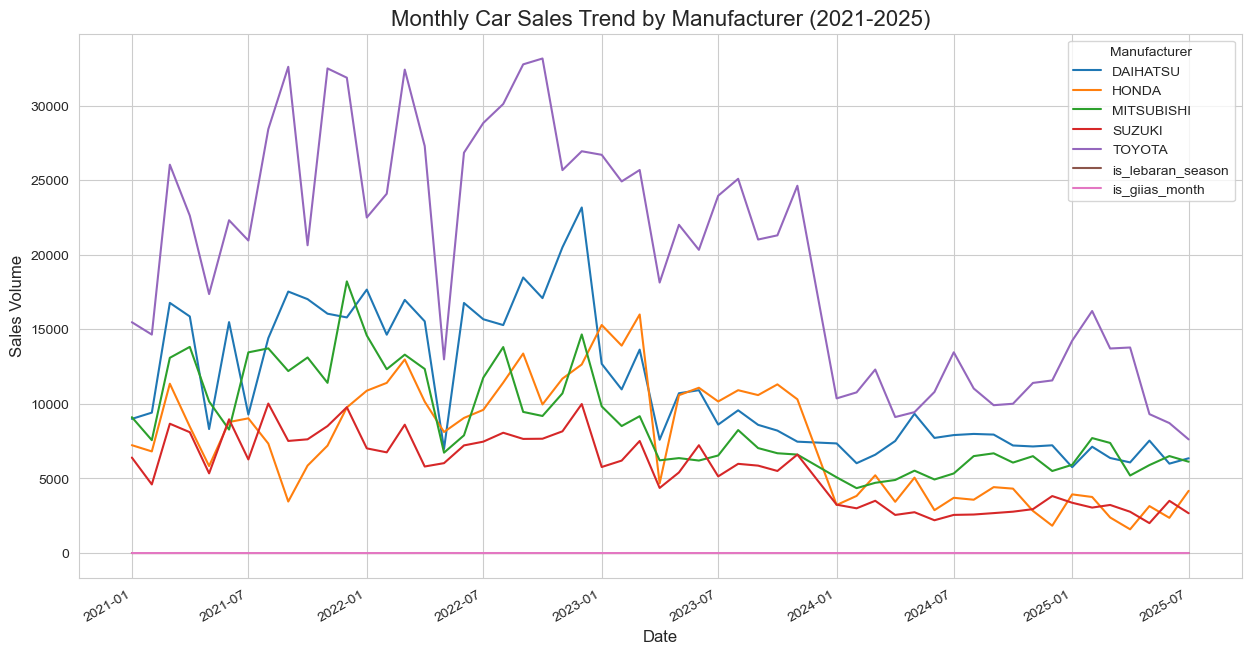

In [75]:
df.plot(figsize=(15, 8), linestyle='-')
plt.title('Monthly Car Sales Trend by Manufacturer (2021-2025)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.legend(title='Manufacturer')
plt.grid(True)
plt.show()

In [76]:
import pandas as pd

# 
df = pd.read_csv('merged_car_sales_with_features.csv')
df['waktu'] = pd.to_datetime(df['waktu'])
df = df.set_index('waktu')


cols_to_clean = ['bi_policy_rate_pct', 'inflation_yoy_pct', 'consumer_confidence_index']
for col in cols_to_clean:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)


def create_features(df):
    """Function to create time-series features from a datetime index."""
    df['month'] = df.index.month
    df['year'] = df.index.year
    # df['quarter'] = df.index.quarter
    return df

df = create_features(df)

TARGETS = ['DAIHATSU', 'HONDA', 'MITSUBISHI', 'SUZUKI', 'TOYOTA']

for brand in TARGETS:
    df[f'{brand}_lag1'] = df[brand].shift(1)
    df[f'{brand}_lag3'] = df[brand].shift(3)
    # df[f'{brand}_lag12'] = df[brand].shift(12)
    df[f'{brand}_rolling_mean3'] = df[brand].shift(1).rolling(window=3).mean()
    df[f'{brand}_rolling_std3'] = df[brand].shift(1).rolling(window=3).std()

df = df.dropna()


FEATURES = [col for col in df.columns if col not in TARGETS]


X = df[FEATURES]
y = df[TARGETS]

print("--- Successfully created features and split data ---")
print("\nShape of X (features):", X.shape)
print("Shape of y (targets):", y.shape)
print("\n--- First 5 rows of X ---")
print(X.head())

--- Successfully created features and split data ---

Shape of X (features): (51, 27)
Shape of y (targets): (51, 5)

--- First 5 rows of X ---
            bi_policy_rate_pct  inflation_yoy_pct  consumer_confidence_index  \
waktu                                                                          
2021-04-01                 3.5               1.42                      101.5   
2021-05-01                 3.5               1.68                      104.4   
2021-06-01                 3.5               1.33                      107.4   
2021-07-01                 3.5               1.52                       80.2   
2021-08-01                 3.5               1.59                       77.3   

            is_lebaran_season  is_giias_month  month  year  DAIHATSU_lag1  \
waktu                                                                       
2021-04-01                  1               0      4  2021        16770.0   
2021-05-01                  1               0      5  2021       

In [77]:

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
import scipy.stats as stats# --- Data Splitting ---
TRAIN_END = '2024-12-31'
X_train, y_train = X.loc[X.index <= TRAIN_END], y.loc[y.index <= TRAIN_END]
X_val, y_val = X.loc[X.index > TRAIN_END], y.loc[y.index > TRAIN_END]

print(f"Training data period: {X_train.index.min()} to {X_train.index.max()}")
print(f"Validation data period: {X_val.index.min()} to {X_val.index.max()}")


param_grid_lgb = {
    'n_estimators': stats.randint(800, 2500),
    'learning_rate': stats.uniform(0.01, 0.1),
    'max_depth': stats.randint(3, 10), 
    'num_leaves': stats.randint(20, 50), #
    'subsample': stats.uniform(0.5, 0.5),
    'colsample_bytree': stats.uniform(0.5, 0.5),
    'reg_lambda': stats.uniform(1, 4),
    'reg_alpha': stats.uniform(0, 1)
}

models = {}
for target in TARGETS:
    print(f"\nTraining and tuning LightGBM model for {target}...")
    
    # 2. LightGBM
    model = lgb.LGBMRegressor(
        objective='regression',  # 
        # device='gpu',    
        random_state=42
    )
    
    # 3. RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid_lgb,
        n_iter=100,
        cv=5,
        scoring='neg_root_mean_squared_error',
        verbose=1,
        random_state=42,
        n_jobs=2
    )
    
    random_search.fit(
        X_train, y_train[target],
        eval_set=[(X_val, y_val[target])],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    # 5. 最も性能が良かったモデルを保存
    print(f"Best parameters for {target}: {random_search.best_params_}")
    models[target] = random_search.best_estimator_

Training data period: 2021-04-01 00:00:00 to 2024-12-01 00:00:00
Validation data period: 2025-01-01 00:00:00 to 2025-07-01 00:00:00

Training and tuning LightGBM model for DAIHATSU...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 24
[LightGBM] [Info] Start training from score 11985.364458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [78]:
# Define the SMAPE function
def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE).
    The result is returned as a percentage (e.g., 15.0 for 15%).
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Handle the case where the denominator is zero.
    # If both true and predicted are 0, the error is 0.
    ratio = np.where(denominator == 0, 0, numerator / denominator)
    return np.mean(ratio) * 100

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

# Create a list to store the evaluation results
evaluation_results = []

# Loop through each trained model
for target, model in models.items():
    # Make predictions on the validation data
    y_pred = model.predict(X_val)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_val[target], y_pred)
    mse = mean_squared_error(y_val[target], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val[target], y_pred)
    smape_score = smape(y_val[target], y_pred)
    
    # Store the results in a dictionary
    results = {
        'Brand': target,
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r2,
        'SMAPE (%)': smape_score  # <-- Added SMAPE here
    }
    evaluation_results.append(results)

# Convert the list of results into a pandas DataFrame
results_df = pd.DataFrame(evaluation_results)

# Display the evaluation metrics, sorted by SMAPE
print("\n--- Model Evaluation Metrics (including SMAPE) ---")
print(results_df.sort_values(by='SMAPE (%)').reset_index(drop=True))


--- Model Evaluation Metrics (including SMAPE) ---
        Brand          MAE         RMSE  R-squared  SMAPE (%)
0    DAIHATSU   704.049737   746.361405  -0.567310  10.556061
1  MITSUBISHI   949.512761  1045.014612  -0.629844  14.547200
2      SUZUKI   507.015735   641.863739  -0.837575  17.063293
3       HONDA   936.408007  1045.065497  -0.366068  30.875490
4      TOYOTA  3743.212376  4125.607725  -0.800718  31.526027


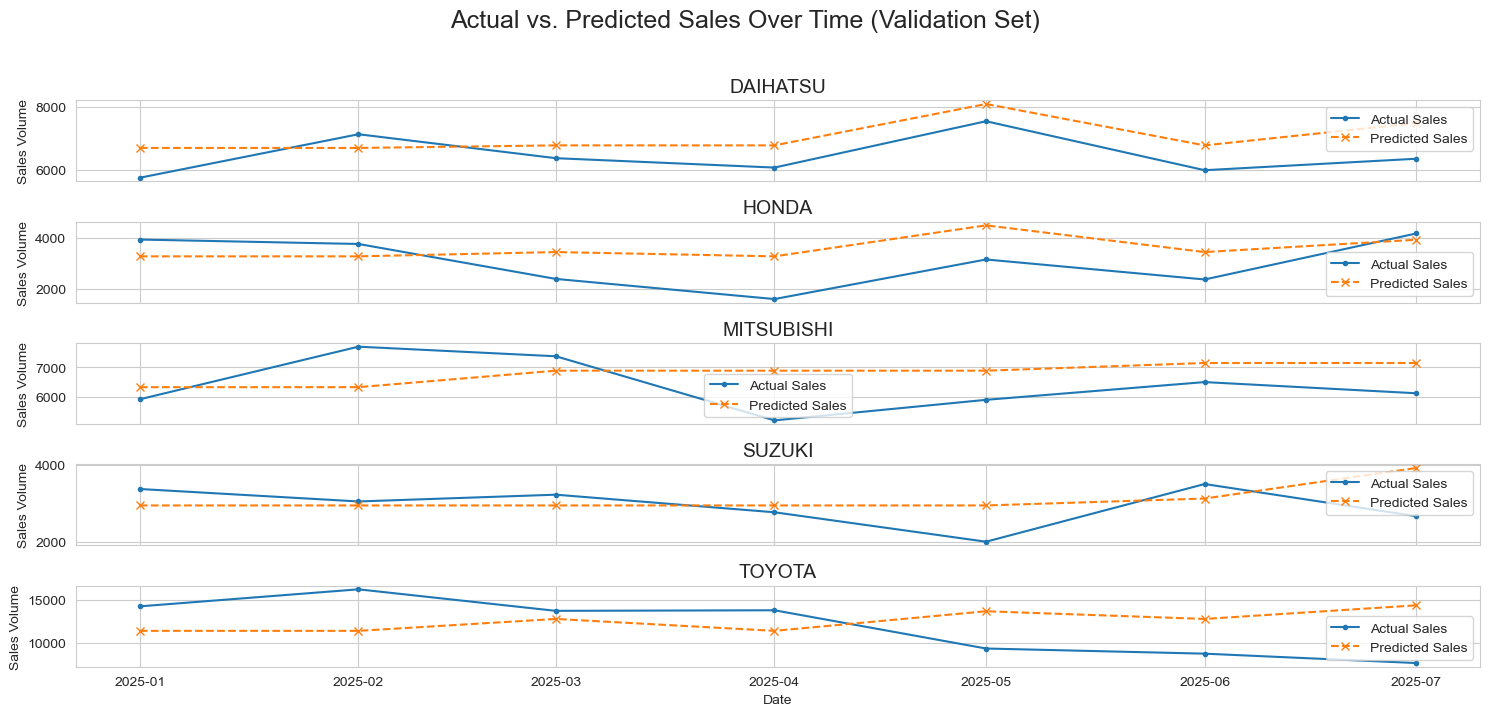

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style for the plots
sns.set_style('whitegrid')

# Create subplots to visualize each model's predictions
# This will create a separate chart for each brand for clarity
fig, axes = plt.subplots(nrows=len(TARGETS), ncols=1, figsize = (15, 8), sharex=True)
fig.suptitle('Actual vs. Predicted Sales Over Time (Validation Set)', fontsize=18, y=0.92)

for i, target in enumerate(TARGETS):
    # Get the specific subplot
    ax = axes[i]
    
    # Use the trained model for the brand to make predictions
    y_pred = models[target].predict(X_val)
    
    # Plot the actual sales data from the validation set
    ax.plot(y_val.index, y_val[target], label='Actual Sales', marker='.', linestyle='-')
    
    # Plot the model's predicted sales on top
    ax.plot(y_val.index, y_pred, label='Predicted Sales', marker='x', linestyle='--')
    
    # Set titles and labels for clarity
    ax.set_title(target, fontsize=14)
    ax.set_ylabel('Sales Volume')
    ax.legend()

plt.xlabel('Date')
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

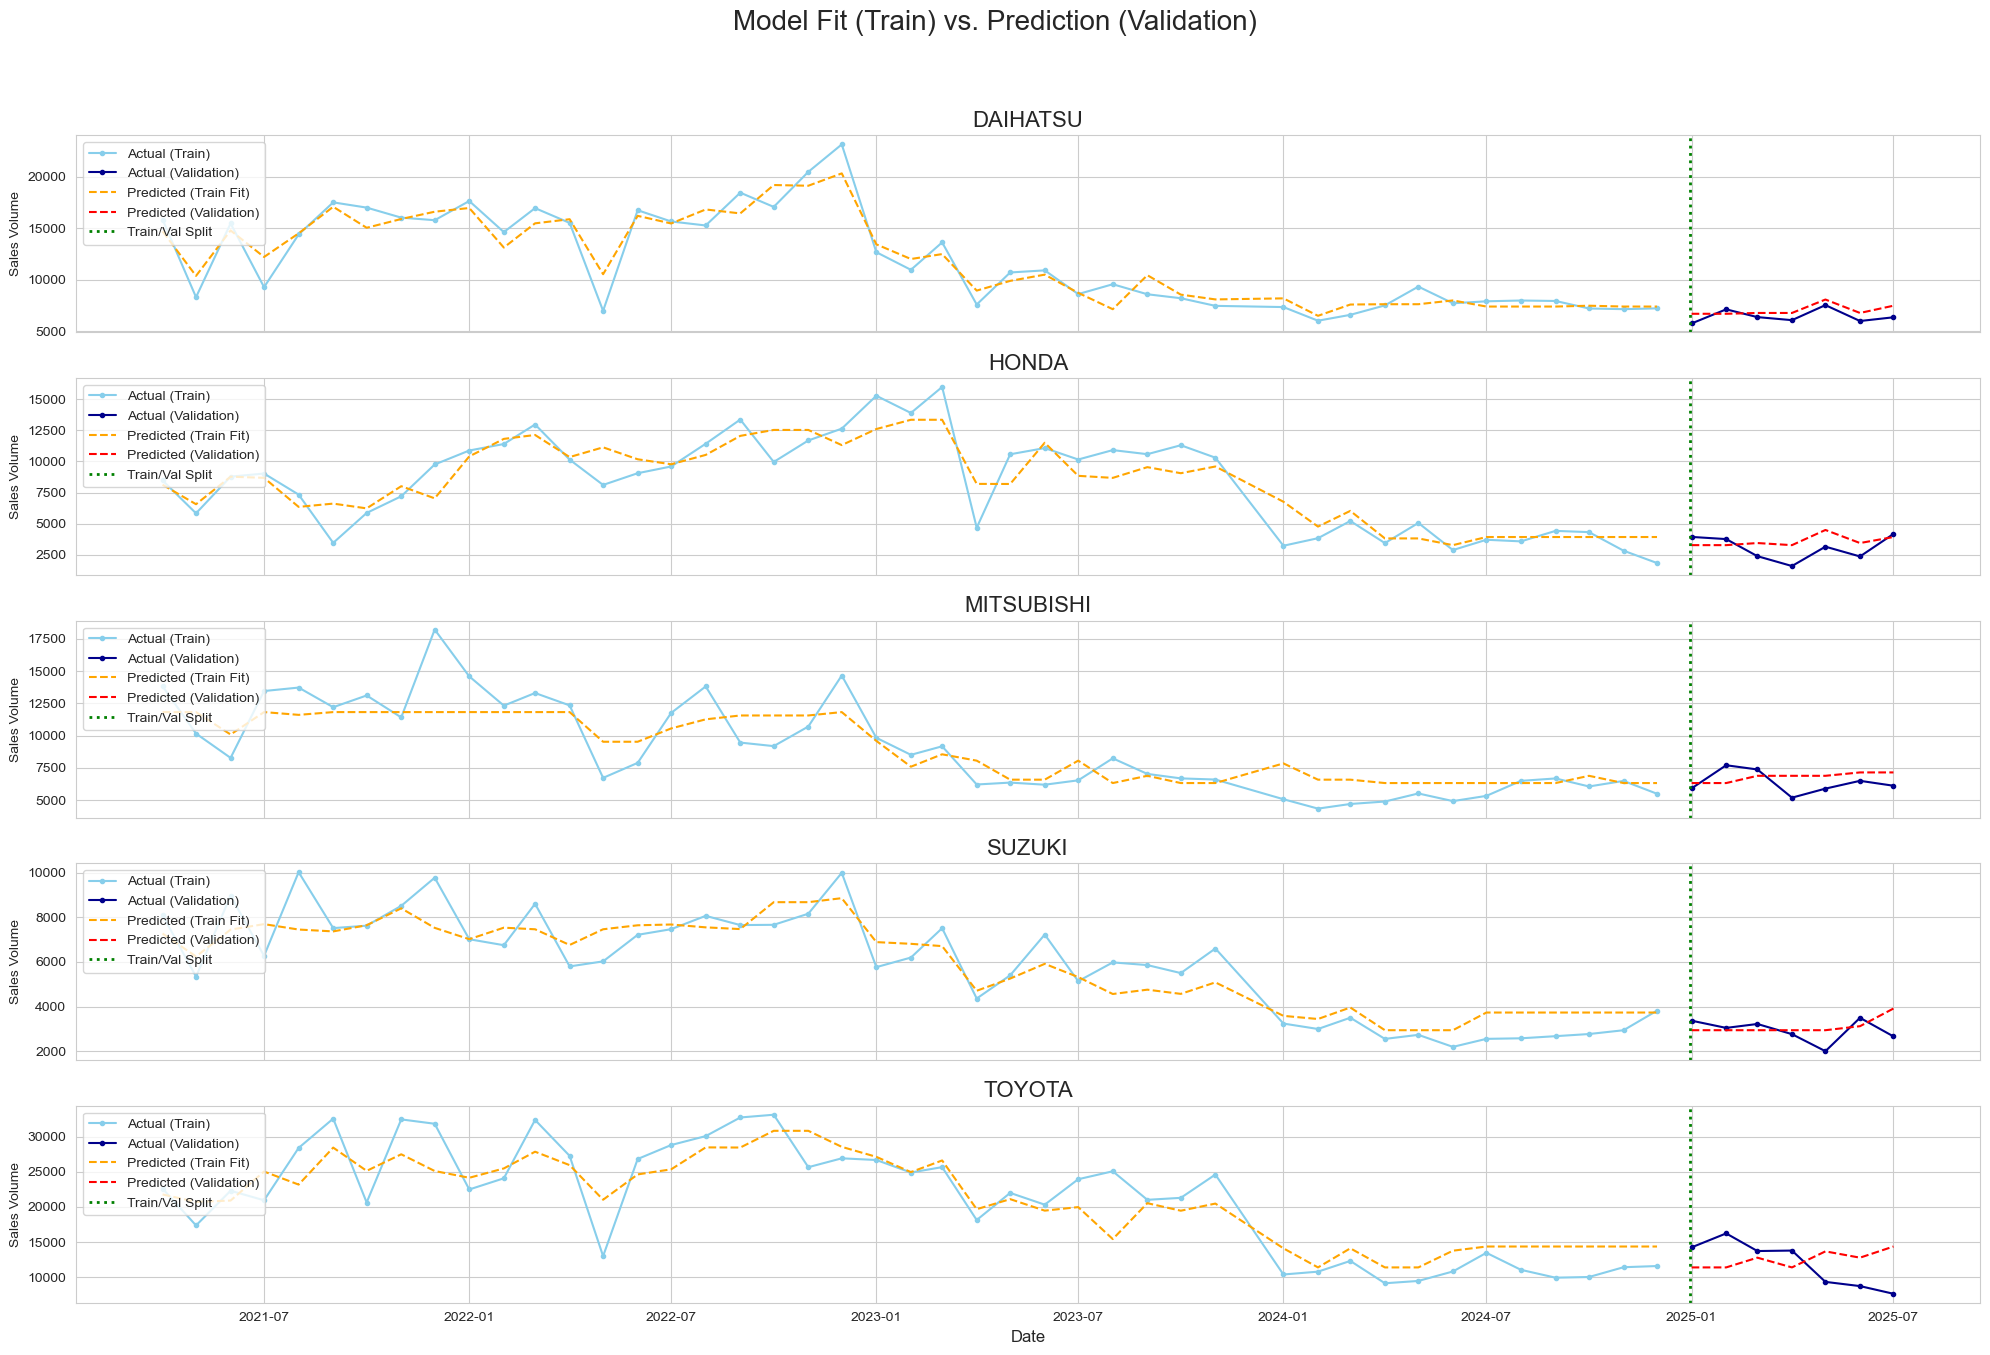

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # T

sns.set_style('whitegrid')


fig, axes = plt.subplots(nrows=len(TARGETS), ncols=1, figsize=(20, 15), sharex=True)
fig.suptitle('Model Fit (Train) vs. Prediction (Validation)', fontsize=20, y=0.93)

for i, target in enumerate(TARGETS):
    ax = axes[i]
    
    pred_train = models[target].predict(X_train)
    pred_val = models[target].predict(X_val)
    
    ax.plot(y_train.index, y_train[target], label='Actual (Train)', color='skyblue', marker='.', linestyle='-')
    ax.plot(y_val.index, y_val[target], label='Actual (Validation)', color='darkblue', marker='.', linestyle='-')
    
    ax.plot(X_train.index, pred_train, label='Predicted (Train Fit)', linestyle='--', color='orange')
    ax.plot(X_val.index, pred_val, label='Predicted (Validation)', linestyle='--', color='red')
    

    ax.axvline(pd.to_datetime(TRAIN_END), color='green', linestyle=':', lw=2, label='Train/Val Split')


    ax.set_title(target, fontsize=16)
    ax.set_ylabel('Sales Volume')
    ax.legend(loc='upper left')

plt.xlabel('Date', fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

In [81]:
import numpy as np

# --- 季節性ナイーブ予測の作成 ---
# 検証期間y_valに対応する、1年前の訓練期間のデータを取得
y_train_seasonal_naive = y_train.loc[y_val.index - pd.DateOffset(years=1)]

# SMAPEを計算する関数 (再掲)
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    ratio = np.where(denominator == 0, 0, numerator / denominator)
    return np.mean(ratio) * 100

# 全ブランドで評価
for target in TARGETS:
    # y_val[target] (実際の値) と y_train_seasonal_naive[target] (1年前の値) を比較
    naive_smape = smape(y_val[target].values, y_train_seasonal_naive[target].values)
    print(f"Seasonal Naive Forecast SMAPE for {target}: {naive_smape:.2f}%")

Seasonal Naive Forecast SMAPE for DAIHATSU: 19.13%
Seasonal Naive Forecast SMAPE for HONDA: 35.38%
Seasonal Naive Forecast SMAPE for MITSUBISHI: 24.12%
Seasonal Naive Forecast SMAPE for SUZUKI: 14.64%
Seasonal Naive Forecast SMAPE for TOYOTA: 28.81%


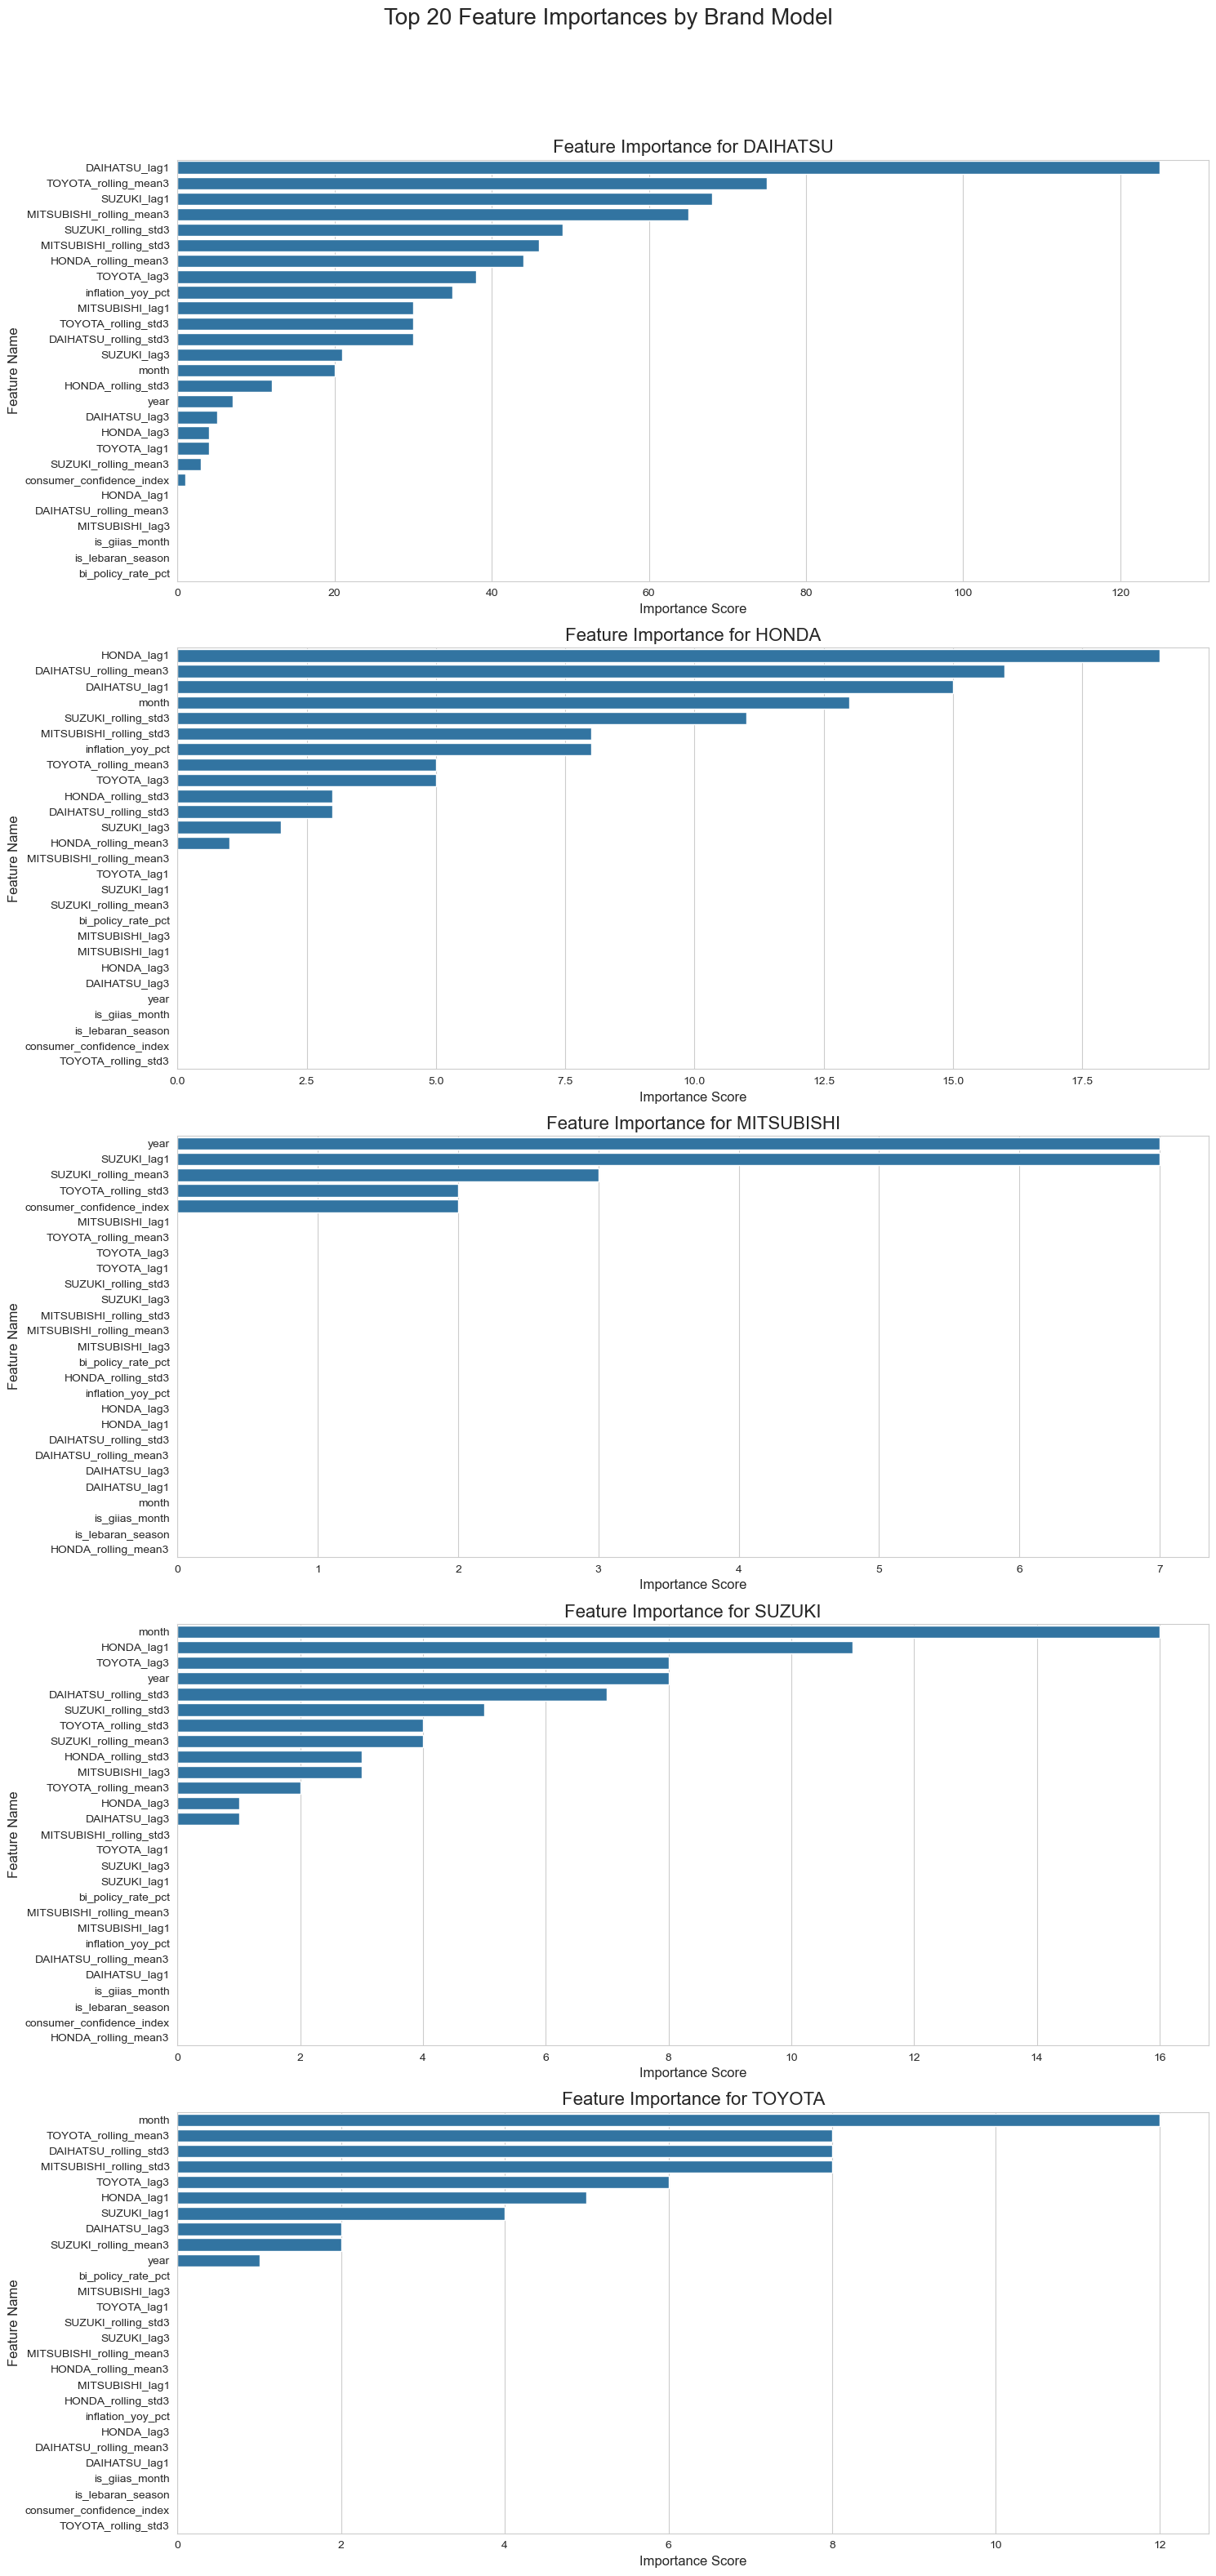

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# グラフのスタイルを設定
sns.set_style("whitegrid")

# 各ブランドのグラフを縦に並べて表示するための準備
num_targets = len(TARGETS)
fig, axes = plt.subplots(nrows=num_targets, ncols=1, figsize=(15, 7 * num_targets))

# ターゲットが1つの場合でもエラーにならないように調整
if num_targets == 1:
    axes = [axes]

fig.suptitle('Top 20 Feature Importances by Brand Model', fontsize=20, y=0.93)

# 各ブランドの学習済みモデルに対してループ処理
for i, (target, model) in enumerate(models.items()):
    ax = axes[i]
    
    # 特徴量の名前と、その重要度をデータフレームにまとめる
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
    })
    
    # 重要度が高い順にソートし、上位20個を抽出
    top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(40)
    
    # 棒グラフを作成
    sns.barplot(x='Importance', y='Feature', data=top_features, ax=ax)
    
    ax.set_title(f'Feature Importance for {target}', fontsize=16)
    ax.set_xlabel('Importance Score', fontsize=12)
    ax.set_ylabel('Feature Name', fontsize=12)

# グラフのレイアウトを調整して表示
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()